In [29]:
import pandas as pd
import numpy as np
import torch
import torch.nn
import os
import re

import matplotlib.pyplot as plt

In [310]:
data = pd.read_feather("../../data_preprocessing/filtered_data.feather")

In [311]:
def preprocess_text(x: pd.Series) -> list[str]: 
    x_ = x.copy()
    x_ = x_.apply(lambda x: x.replace('\n', ' '))
    x_ = x_.apply(lambda x: x.replace('\u2005', ' '))
    x_ = [re.sub(r'\[.*?\]\s*', '', line) for line in x_]
    x_ = [re.sub(r'\(.*?\)\s*', '', line) for line in x_]
    return x_

data["processed_lyrics"] = preprocess_text(data.lyrics)

In [300]:
def plot_word_length(strings_list, title):
    word_counts = [len(s.split()) for s in strings_list]

    plt.figure(figsize = (6,3), dpi=300)
    plt.hist(word_counts, bins=100)

    plt.xlabel('Number of Words')
    plt.ylabel('Frequency')
    plt.xlim(-10, 6000)
    plt.title(title)

    plt.show()
    return word_counts

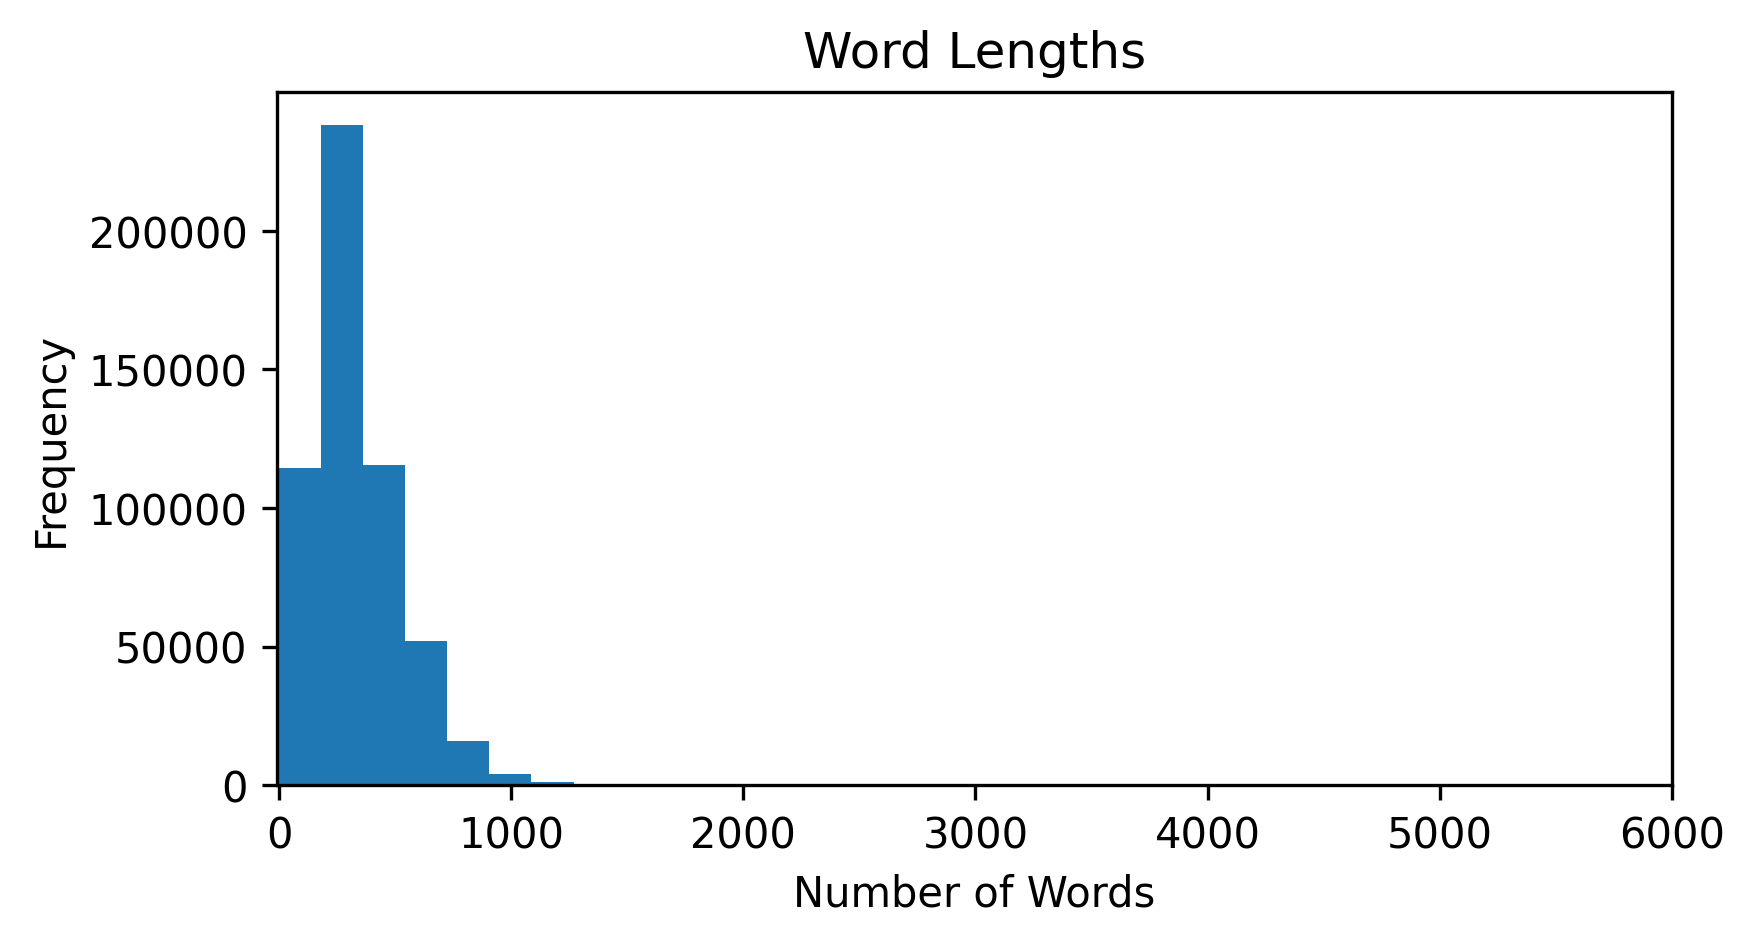

In [312]:
word_counts = plot_word_length(data.processed_lyrics, "Word Lengths")

In [313]:
mask = (pd.Series(word_counts) < 1000)
filtered_data = data[mask]
filtered_data = filtered_data[~(filtered_data.artist == "Glee Cast")]

In [314]:
genre_breakdown = filtered_data.tag.value_counts()
genre_breakdown

tag
pop        181300
rap        177940
rock       128971
rb          34507
country     15380
Name: count, dtype: int64

In [315]:
top_10000_per_genre = pd.DataFrame()

for genre in genre_breakdown.index:
    genre_data = filtered_data[filtered_data["tag"] == genre]
    top_10000 = genre_data.sort_values("views", ascending=False).iloc[:10000, :]
    top_10000_per_genre = pd.concat([top_10000_per_genre, top_10000])

filtered_data = top_10000_per_genre.reset_index(drop=True)


In [316]:
for genre in genre_breakdown.index:
    print(genre + ": \n " + "-"* 20)
    genre_data = filtered_data[filtered_data["tag"] == genre]
    print(genre_data.artist.value_counts()[:15])

pop: 
 --------------------
artist
Lana Del Rey         131
Taylor Swift         103
One Direction         83
Justin Bieber         81
Ed Sheeran            78
Beyonc                78
Little Mix            72
Lady Gaga             71
Ariana Grande         70
Shawn Mendes          66
twenty one pilots     60
Billie Eilish         57
Halsey                55
Rihanna               54
Katy Perry            52
Name: count, dtype: int64
rap: 
 --------------------
artist
Drake                         215
Eminem                        198
Lil Wayne                     174
Kanye West                    156
J. Cole                       134
JAY-Z                         128
Juice WRLD                    126
Future                        123
$UICIDEBOY$                   120
Logic                         112
Meek Mill                     112
YoungBoy Never Broke Again    107
Mac Miller                    103
Young Thug                    101
Lil Uzi Vert                  101
Name: count, dtype:

## Train Test Split

In [317]:
from sklearn.model_selection import train_test_split

In [411]:
x = filtered_data.processed_lyrics
y = filtered_data.tag

In [412]:
X_, X_test, y_, y_test = train_test_split(x, y, random_state=1234, test_size=0.5, stratify=y)
X_train, X_valid, y_train, y_valid = train_test_split(X_, y_, random_state=1234, test_size=0.4, stratify=y_)
del X_, y_

In [413]:
from sklearn.preprocessing import OneHotEncoder

In [414]:
ohe = OneHotEncoder()
y_ohe = ohe.fit_transform(np.array(y_train).reshape(1,-1)).toarray()

In [415]:
y_ohe

array([[1., 1., 1., ..., 1., 1., 1.]])

## Dataset Loader

In [416]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import AutoTokenizer

class TextDataset:
    def __init__(self, text_dataset, labels, max_length=128, batch_size=32) -> None:
        assert len(text_dataset) == len(labels), "Text samples does not match Labels"
        self.ohe = OneHotEncoder()
        checkpoint = "distilbert-base-uncased"
        self.text_dataset = list(text_dataset)
        self.text_labels = self.ohe.fit_transform(np.array(labels).reshape(1,-1)).toarray()[0]
        self.num_classes = len(set(labels))
        self.max_length = max_length
        self.batch_size = batch_size
        
        self.tokenizer = AutoTokenizer.from_pretrained(checkpoint)
        
        # Tokenize the dataset
        self.input_ids, self.attention_masks = self.tokenize()
        
        # Create the DataLoader and save it internally
        self.dataloader = self.create_dataloader()
        
    def __len__(self):
        return len(self.text_dataset)
    
    def to_dataframe(self):
        return pd.DataFrame({
            "Text": self.text_dataset,
            "Label": self.ohe.inverse_transform(self.text_labels.reshape(1,-1))[0]
        })
    
    def __repr__(self):
        return repr(self.to_dataframe())
    
    def tokenize(self):
        inputs = self.tokenizer.batch_encode_plus(
            self.text_dataset,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            return_attention_mask=True,
            return_token_type_ids=False,
            truncation=True,
            return_tensors="np"
        )
        
        input_ids = np.asarray(inputs['input_ids'], dtype='int32')
        attention_masks = np.asarray(inputs['attention_mask'], dtype='int32')
        
        return input_ids, attention_masks
    
    def create_dataloader(self, shuffle_data=True):
        labels_tensor = torch.tensor(self.text_labels, dtype=torch.long)
        input_ids_tensor = torch.tensor(self.input_ids, dtype=torch.long)
        attention_masks_tensor = torch.tensor(self.attention_masks, dtype=torch.long)
        
        dataset = TensorDataset(input_ids_tensor, attention_masks_tensor, labels_tensor)
        
        return DataLoader(dataset, batch_size=self.batch_size, shuffle=shuffle_data)
    
    def get_dataloader(self):
        return self.dataloader


In [417]:
training_set = TextDataset(X_train, y_train)
validation_set = TextDataset(X_valid, y_valid)
testing_set = TextDataset(X_test, y_test)

In [418]:
training_set

                                                    Text    Label
0      Oh, put your lovin' hand out, baby I'm beggin'...      rap
1      Do you recall, not long ago We would walk on t...      pop
2      Now it's time, I fear to tell I've been holdin...       rb
3      And hell is just a government creation And all...      rap
4      I'm not supposed to be thinking 'bout you, lyi...  country
...                                                  ...      ...
14995  My love is, working hard yadadamean? My love i...      rap
14996  Somebody stepped inside your soul Somebody ste...     rock
14997  Said, "In truth, I don't really want to talk a...     rock
14998  Oh-oh It's a motherfuckin' cigarette, nigga Sm...      rap
14999  One, one, one, one, one  Talkin' in my sleep a...      pop

[15000 rows x 2 columns]

In [419]:
testing_set

                                                    Text    Label
0      This feeling, it's something when you call me ...      pop
1      Yeah Oh-oh, yeah  I've been meaning to fuck yo...       rb
2      You ain't gon' be shit All your life they said...      rap
3      Has it been a year, since the last time I've s...  country
4      I'm like a crow on a wire You're the shining d...      pop
...                                                  ...      ...
24995  , niggas sayin' they outside Niggas sayin' the...      rap
24996  Fuck you, bitch, I'm here all by myself I trie...      rap
24997  Wanna know who burned you so bad Left your hea...  country
24998  Risky, risky Yes, yuh body risky Risky Weh! Tr...      pop
24999  I said, "Settle down, settle down, everything ...     rock

[25000 rows x 2 columns]

In [420]:
validation_set

                                                   Text Label
0     Come on, come on, come on, come on Come on, it...  rock
1     I'm tryin' to go to church Get some chicken wi...   rap
2     Now she wanna fuck with me Live a life of luxu...    rb
3     We broke Everything that was right we both enj...   pop
4     There was blood in my tears "thgir ton s'ti - ...   rap
...                                                 ...   ...
9995  Hmmm... A left turn here...  Er... I'm glad yo...   pop
9996  But it's all the same I could have foreseen Th...    rb
9997  Yeah, check it out, see The only thing you nee...   rap
9998  Here we go!  I can't wait to smoke them all Wh...   pop
9999  Yeah yeah Yeah yeah Finna put you on tripsss Y...   pop

[10000 rows x 2 columns]

## Pytorch Distilbert

In [421]:
import torch.nn as nn
from transformers import DistilBertConfig,DistilBertTokenizer,DistilBertModel
from transformers import AutoTokenizer

In [422]:
%%bash
export PYDEVD_DISABLE_FILE_VALIDATION=1

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [423]:
checkpoint="distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

batch_size = 1
max_length = 256
rate = 0.5
num_labels = 5

In [333]:
import pandas as pd
from transformers import AutoTokenizer
from sklearn.utils import shuffle

class text_dataset:
    def __init__(self, text_dataset, labels) -> None:
        assert len(text_dataset) == len(labels), "Text samples does not match Labels"
        checkpoint = "distilbert-base-uncased"
        self.text_dataset = list(text_dataset)
        self.text_labels = ohe.transform(list(labels))
        self.num_classes = len(set(labels))
        
        self.tokenizer = AutoTokenizer.from_pretrained(checkpoint)
        
    def __len__(self):
        return len(self.text_dataset)
    
    def to_dataframe(self):
        return pd.DataFrame({
            "Text": self.text_dataset,
            "Label": self.text_labels
        })
    
    def __repr__(self):
        return repr(self.to_dataframe())
    
    def tokenize(self):
        self.tokenizer.batch_encode_plus(list(self.text_dataset), add_special_tokens=True, max_length=max_length,
                                         padding='max_length', return_attention_mask=True,
                                         return_token_type_ids=True, truncation=True,
                                         return_tensors="np")
        input_ids = np.asarray(inputs['input_ids'], dtype='int32')
        attention_masks = np.asarray(inputs['attention_mask'], dtype='int32')    
        DataLoader()


In [ ]:
y_train

[0, 1, 0]

In [291]:
X_valid

27231    Come on, come on, come on, come on Come on, it...
15604    I'm tryin' to go to church Get some chicken wi...
31149    Now she wanna fuck with me Live a life of luxu...
7927     We broke Everything that was right we both enj...
14781    There was blood in my tears "thgir ton s'ti - ...
                               ...                        
9592     Hmmm... A left turn here...  Er... I'm glad yo...
31055    But it's all the same I could have foreseen Th...
13921    Yeah, check it out, see The only thing you nee...
3456     Here we go!  I can't wait to smoke them all Wh...
8597     Yeah yeah Yeah yeah Finna put you on tripsss Y...
Name: processed_lyrics, Length: 10000, dtype: object

In [292]:
y_valid

27231    rock
15604     rap
31149      rb
7927      pop
14781     rap
         ... 
9592      pop
31055      rb
13921     rap
3456      pop
8597      pop
Name: tag, Length: 10000, dtype: object